# Rule-based control of a solar home

This simple control schem can be used as an example of how to use the solar home test bench in Python.

Pierre Haessig, July 2019

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Import solarhome utility module

In [3]:
from pathlib import Path
p_utils = Path('../../utils')
assert p_utils.exists()

import sys
sys.path.append(str(p_utils))

import benchutils as bu

### Load testcase data

In [4]:
params, data = bu.load_data()
data.head(3)

,P_load_sp,P_sun_1k,c_grid
0.0,0.520,0.0,0.1
0.5,0.528,0.0,0.1
1.0,0.496,0.0,0.1


In [5]:
n = len(data)
ndays = n//48 # days
ndays

30

Solar home parameters:

In [6]:
E_rated = params['E_rated'] # kWh
P_pvp = params['P_pvp'] # kW
print('E_rated: {:.1f} kWh'.format(E_rated))
print('P_pvp: {:.1f} kW'.format(P_pvp))

E_rated: 8.0 kWh
P_pvp: 4.0 kW


In [7]:
P_grid_max = 3 # kW

Extract time series of test data

In [8]:
P_load = data.P_load_sp
P_sun = data.P_sun_1k*P_pvp
c_grid = data.c_grid

t = data.index
dt = t[1] - t[0]
td = t/24 #days

In [9]:
print('Average sun energy: {:.2f} kWh/d'.format(P_sun.mean()*24))
print('Average load      : {:.2f} kWh/d'.format(P_load.mean()*24))
print('ratio sun/load: {:.2%}'.format(P_sun.mean()/P_load.mean()))

Average sun energy: 15.60 kWh/d
Average load      : 17.02 kWh/d
ratio sun/load: 91.70%


Demo plot of input data

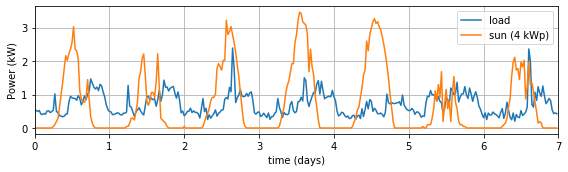

In [11]:
fig, ax = plt.subplots(1,1, figsize=(8,2.5))
z = slice(0, 7*48)
ax.plot(td[z], P_load.iloc[z], label='load', color='tab:blue')
ax.plot(td[z], P_sun.iloc[z], label='sun ({} kWp)'.format(P_pvp), color='tab:orange')

ax.legend()
ax.grid(True)

ax.set(
    xlim = (0,7),
    xlabel = 'time (days)',
    ylabel = 'Power (kW)'   
)
fig.tight_layout()

## Rule based control

control rules:

* storage should follow the net load as much as possible: $P_{sto} = -P_{nl} = P_{sun} - P_{load} $
* if empty, use grid instead
* if full, curtail the excess of production

inputs: $P_{sun}$, $P_{load}$ and storage state $E_{sto}$

Outputs: $P_{sto}$, $P_{grid}$, $P_{curt}$

def: net load: $P_{nl} = P_{load} - P_{sun}$

* if $P_{nl}>0$ (load > sun)
  * if battery not empty: battery discharge to follow net load $P_{sto} = -P_{nl} <0 $, $P_{grid} = 0$.
  * if battery is empty, use the grid instead: $P_{grid} = P_{nl}$
* if $P_{nl}<0$ (sun > load)
  * if battery not full: battery charges to absorbe net production $P_{sto} = -P_{nl} > 0$, $P_{grid} = 0$.
  * if battery is full, curtail the excess of production: $P_{curt} = -P_{nl}$, so that $P_{sun} - P_{curt} = P_{pv} = P_{load}$. $P_{grid} = 0$

In [12]:
def control(P_sun, P_load, E_sto):
    P_nl = P_load - P_sun
    # outputs:
    P_sto = 0
    P_grid = 0
    P_curt = 0
    
    E_next = E_sto - P_nl*dt
    
    if P_nl>0: # (load > sun)
        E_next = E_next if E_next>0. else 0.
        P_sto = (E_next - E_sto)/dt # <0
        P_grid = P_nl + P_sto
    else:
        E_next = E_next if E_next<E_rated else E_rated
        P_sto = (E_next - E_sto)/dt # >0
        P_curt = -P_nl - P_sto
    return P_sto, P_grid, P_curt

In [13]:
control(1,3, 5)

(-2.0, 0.0, 0)

In [14]:
control(1,3, 0)

(0.0, 2.0, 0)

In [15]:
control(1,3, 0.1*dt)

(-0.1, 1.9, 0)

In [16]:
control(3,1, 5)

(2.0, 0, 0.0)

In [17]:
control(3,1, E_rated)

(0.0, 0, 2.0)

In [18]:
control(3,1, E_rated-0.1*dt)

(0.09999999999999964, 0, 1.9000000000000004)

### Simulation loop

In [20]:
P_sto = np.zeros(n)
E_sto = np.zeros(n+1)
P_grid = np.zeros(n)
P_curt = np.zeros(n)

E_sto[0]= E_rated/2

for k in range(n):
    P_sto[k], P_grid[k], P_curt[k] = control(P_sun.values[k], P_load.values[k], E_sto[k])
    E_sto[k+1] = E_sto[k] + P_sto[k]*dt
    assert 0 <= E_sto[k+1] <= E_rated

    
E_sto = E_sto[:-1]
P_pv = P_sun - P_curt
P_nl = P_load - P_sun

Collect all trajectory variables

In [21]:
traj = pd.DataFrame(
    data = {
        'E_sto': E_sto, # state 
        'P_sto': P_sto, # out

        'P_load_sp': P_load,
        'P_shed': np.zeros_like(P_load),
        'P_load': P_load,

        'P_sun' : P_sun,
        'P_curt': P_curt,
        'P_pv'  : P_sun - P_curt,

        'P_grid': P_grid,
        'c_grid': c_grid,
    }, index=t
)
traj.index.name = 't'
traj.head(3)

,E_sto,P_sto,P_load_sp,P_shed,P_load,P_sun,P_curt,P_pv,P_grid,c_grid
t,,,,,,,,,,
0.0,4.000,-0.520,0.520,0.0,0.520,0.0,0.0,0.0,4.440892e-16,0.1
0.5,3.740,-0.528,0.528,0.0,0.528,0.0,0.0,0.0,-4.440892e-16,0.1
1.0,3.476,-0.496,0.496,0.0,0.496,0.0,0.0,0.0,-4.440892e-16,0.1


### Performance statistics

In [22]:
stats = bu.compute_stats(traj)
bu.pprint_stats(stats)

P_load:    17.02 kWh/d

P_sun:     15.60 kWh/d (data)
P_curt:     1.94 kWh/d
P_pv:      13.66 kWh/d

P_sto:     0.025 kWh/d

P_grid:     3.38 kWh/d
C_grid:    0.563 €/d



### Plots

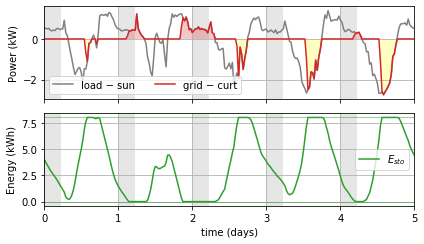

In [24]:
bu.plot_traj(traj[0:24*5], E_rated);

### Write results

In [25]:
bu.save_results('Python_rule-based', params, stats, traj)

result files for method 'Python_rule-based' written!
